170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - loss: 0.0787 - val_loss: 0.0033
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0023 - val_loss: 6.5751e-04
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.0014 - val_loss: 4.8695e-04
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 9.5116e-04 - val_loss: 2.7164e-04
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 6.5588e-04 - val_loss: 1.8940e-04
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 4.7666e-04 - val_loss: 1.7039e-04
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 3.7501e-04 - val_loss: 3.2807e-04
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 3.5963e-04 - val_loss: 4.0775e-04
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 2.5073e-04 - val_loss: 8.8071e-05
Epoch 11/

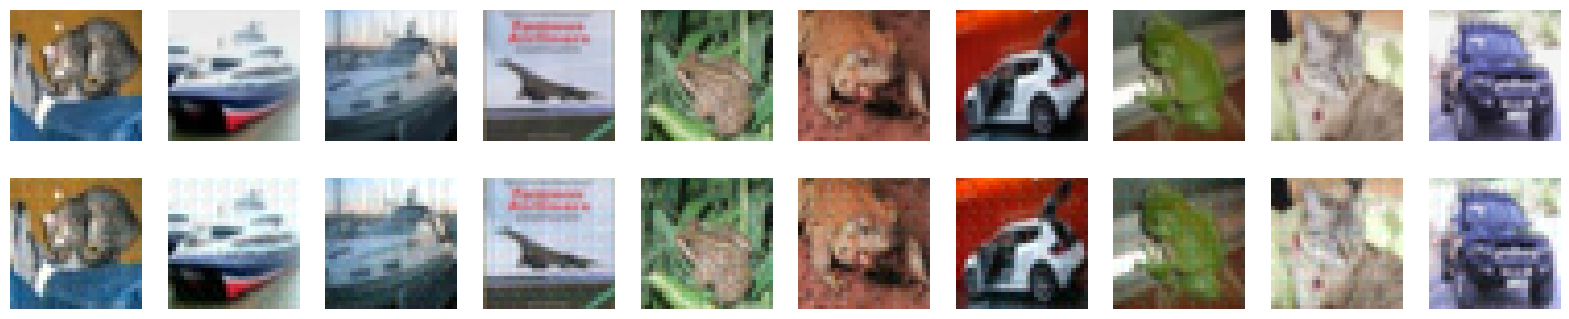

In [ ]:
# Imports and Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Data Preparation
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Patches, Patch Encoder & Patch-to-Image
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

def patch_to_image(patches, patch_size, img_size, channels):
    batch = tf.shape(patches)[0]
    h = img_size // patch_size
    patches = tf.reshape(patches, [batch, h, h, patch_size, patch_size, channels])
    patches = tf.transpose(patches, [0, 1, 3, 2, 4, 5])
    return tf.reshape(patches, [batch, img_size, img_size, channels])

# Transformer Block
def transformer_block(x, num_heads, ff_dim, dropout_rate):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = layers.Dense(ff_dim, activation='relu')(out1)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Transformer-Based Autoencoder Model
def build_autoencoder(image_size, patch_size, projection_dim, num_transformer_layers, num_heads, ff_dim, channels):
    inputs = keras.Input(shape=(image_size, image_size, channels))
    patches = Patches(patch_size)(inputs)
    num_patches = (image_size // patch_size) ** 2
    encoded_tokens = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(num_transformer_layers):
        encoded_tokens = transformer_block(encoded_tokens, num_heads, ff_dim, 0.1)

    latent = encoded_tokens

    decoded_tokens = latent
    for _ in range(num_transformer_layers):
        decoded_tokens = transformer_block(decoded_tokens, num_heads, ff_dim, 0.1)

    patch_dim = patch_size * patch_size * channels
    reconstructed_patches = layers.Dense(patch_dim)(decoded_tokens)
    outputs = layers.Lambda(lambda x: patch_to_image(x, patch_size, image_size, channels))(reconstructed_patches)

    return keras.Model(inputs=inputs, outputs=outputs)

# Model Configuration and Compilation
image_size = 32
patch_size = 4
projection_dim = 64
num_transformer_layers = 4
num_heads = 4
ff_dim = 128
channels = 3

autoencoder = build_autoencoder(
    image_size, patch_size, projection_dim,
    num_transformer_layers, num_heads, ff_dim, channels
)
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

# Model Training
history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_test, x_test)
)

# Visualization of Reconstructions
def display_reconstructions(model, data, n=10):
    reconstructed = model.predict(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.axis("off")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.clip(reconstructed[i], 0, 1))
        plt.axis("off")
    plt.show()

display_reconstructions(autoencoder, x_test)

In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def evaluate_and_reconstruct_image(image_input, model, img_res=(32, 32)):

    width, height = img_res

    # Step 1: Load and resize
    if isinstance(image_input, str):
        img = load_img(image_input, target_size=(height, width))
        img = img_to_array(img) / 255.0

    elif isinstance(image_input, np.ndarray):
        if image_input.ndim == 4:
            img = image_input[0]  # assume batch of 1
        else:
            img = image_input
        img = tf.image.resize(img, (height, width)) / 255.0
        img = img.numpy()

    elif hasattr(image_input, 'resize'):  # PIL.Image
        img = image_input.resize((width, height))
        img = np.array(img) / 255.0

    else:
        raise ValueError("Unsupported image input type")

    # Step 2: Ensure shape is (H, W, 3)
    if img.shape[-1] != 3:
        raise ValueError("Image must have 3 color channels (RGB)")

    img = np.expand_dims(img, axis=0)  # (1, H, W, 3)

    # Step 3: Reconstruct using model
    print("Input shape to model:", img.shape)
    reconstructed = model.predict(img)

    # Step 4: Metrics
    original = np.squeeze(img)
    reconstructed = np.squeeze(reconstructed)
    mse = np.mean((original - reconstructed) ** 2)
    psnr_val = psnr(original, reconstructed, data_range=1.0)
    ssim_val = ssim(original, reconstructed, data_range=1.0, channel_axis=2)

    # Step 5: Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(original, 0, 1))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(reconstructed, 0, 1))
    plt.title("Reconstructed")
    plt.axis("off")
    plt.show()

    # Step 6: Print report
    print("Image Quality Metrics:")
    print(f" - MSE: {mse:.6f}")
    print(f" - PSNR: {psnr_val:.2f} dB")
    print(f" - SSIM: {ssim_val:.4f}")

    return {
        "mse": mse,
        "psnr": psnr_val,
        "ssim": ssim_val,
        "original": original,
        "reconstructed": reconstructed
    }

In [9]:
def get_model_input_shape(model):
    input_shape = model.input_shape
    if isinstance(input_shape, list):  # Some models have multiple inputs
        input_shape = input_shape[0]
    _, height, width, channels = input_shape
    return [width, height]

# Example usage:
supported_input = get_model_input_shape(autoencoder)
print("Supported input size (W x H):", supported_input)

Supported input size (W x H): [32, 32]


Input shape to model: (1, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


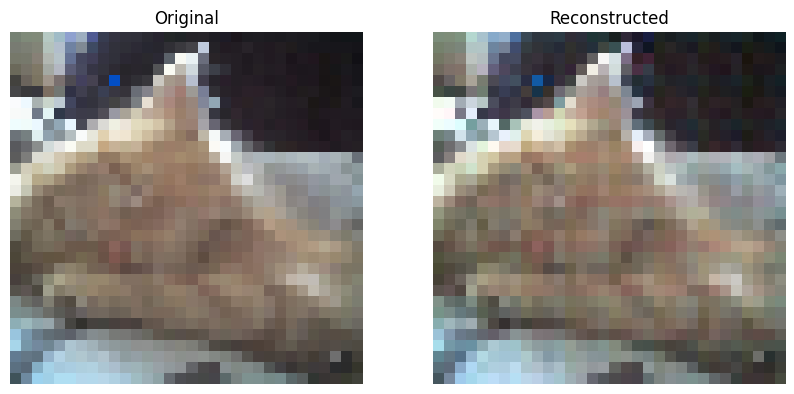

Image Quality Metrics:
 - MSE: 0.000725
 - PSNR: 31.40 dB
 - SSIM: 0.9628


In [10]:
# Using image path and a trained autoencoder model
results = evaluate_and_reconstruct_image("/content/Img_2025_05_29_22_03_10.jpeg", autoencoder, img_res=(32, 32))